In [97]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt

# Dataset
I used Scikit-Image to give me an image. 

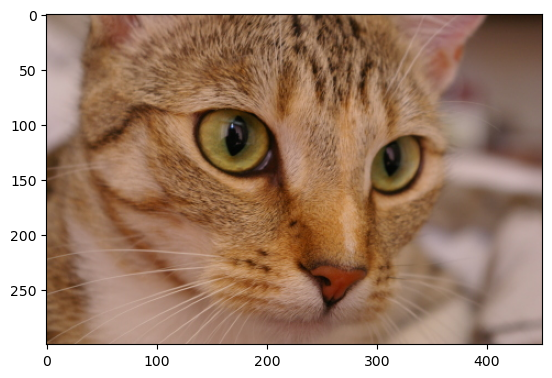

In [98]:
img = skimage.data.cat()
smaller_img = resize(img, (64, 64)) # Resize it just to make things quicker
plt.imshow(img)

In [99]:
def get_mgrid(sidelen):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    width = np.linspace(-1, 1, sidelen)
    height = np.linspace(-1, 1, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

We gain our input coords using the function above. And the outputs y are just the pixel values, so we simply reshape our image into a long 1D array.

In tf.reshape below, the argument [-1, 1] simply means we want the second dimension to be 1, and then the -1 tells Tensorflow to infer the other dimension based on the data. So it just flattens the data.

In [100]:
image_side_length = smaller_img.shape[0]
X = get_mgrid(image_side_length)      # Inputs
y = tf.reshape(smaller_img, [-1, 3])  # Outpus

print(X.shape)
print(y.shape)

(4096, 2)
(4096, 3)


# Model
We can now build our model. We will use the Sequential model builder from Keras to help us do that. It's just a convenient way of stacking layers up... sequentially.

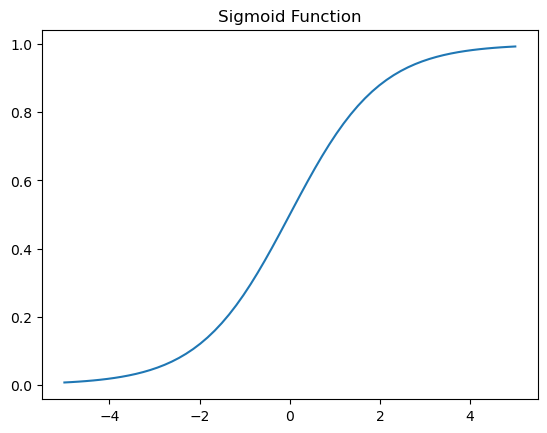

In [101]:
_x = np.linspace(-5, 5, 64)
_y = tf.sigmoid(_x)
plt.title('Sigmoid Function')
plt.plot(_x, _y)

ReLU (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for the other layers is just pretty much standard at this point as it's efficient and simple. 

For now, after defining my sequential model, I compiled it. This is a feature of Keras which gets my model ready for training. I compiled the model with the loss function and the optimizer. I'll use the humble Mean Squared Error and Stochastic Gradient Descent in this case.

In [103]:
# Our model! refer from https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
model = Sequential([
    Dense(16, input_dim=2, activation='relu'),
    Dense(32, activation='softplus'),
    Dense(64, activation='gelu'),
    Dense(128, activation='silu'),
    Dense(256, activation='elu'),
    Dense(3, activation='sigmoid')
])
model.compile(loss='mse', optimizer='sgd')

# Training
Keras makes this simple, I just call model.fit() and pass in the data, number of epochs I would like to train with and the batch size.

In [104]:
model.fit(X, y, epochs=8, batch_size=1)

Epoch 1/8


2023-03-13 23:04:15.787341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4096/4096 [==============================] - 27s 6ms/step - loss: 0.0150
Epoch 2/8
4096/4096 [==============================] - 26s 6ms/step - loss: 0.0146
Epoch 3/8
4096/4096 [==============================] - 31s 8ms/step - loss: 0.0145
Epoch 4/8
4096/4096 [==============================] - 27s 6ms/step - loss: 0.0144
Epoch 5/8
4096/4096 [==============================] - 26s 6ms/step - loss: 0.0142
Epoch 6/8
4096/4096 [==============================] - 26s 6ms/step - loss: 0.0141
Epoch 7/8
4096/4096 [==============================] - 26s 6ms/step - loss: 0.0140
Epoch 8/8
4096/4096 [==============================] - 26s 6ms/step - loss: 0.0138


# Using the Model


In [105]:
# Our traning data is stored in 'X', so lets pass that
# into our trained model and see what it produces.
prediction = model.predict(X)

# Our 'y' training data was a 1D array remember, so it 
# makes sense that the output of our model is the same.
print(prediction.shape)

2023-03-13 23:08:01.949248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(4096, 3)


In [106]:
# Look at the first 10 values of the output.
print(prediction[:10])

[[0.55276597 0.41420096 0.30317134]
 [0.552796   0.41382796 0.3031688 ]
 [0.55282825 0.4134584  0.30316976]
 [0.5528627  0.41309232 0.30317417]
 [0.55289936 0.41272965 0.30318213]
 [0.5529383  0.41237047 0.3031937 ]
 [0.5529793  0.4120148  0.30320883]
 [0.55302244 0.41166258 0.3032277 ]
 [0.55306774 0.41131395 0.30325025]
 [0.55311525 0.41096872 0.30327648]]


I used the Sigmoid activation on the output layer to keep the values between [0, 1]. But to be sure I can check the minimum and maximum values.

In [107]:
min_val = prediction.min()
max_val = prediction.max()

print(min_val, max_val)

0.3031688 0.619097


Finally, before I can view the image I need to do some more data reshaping. I'm going wrap this little routine into a function which can call again later on.

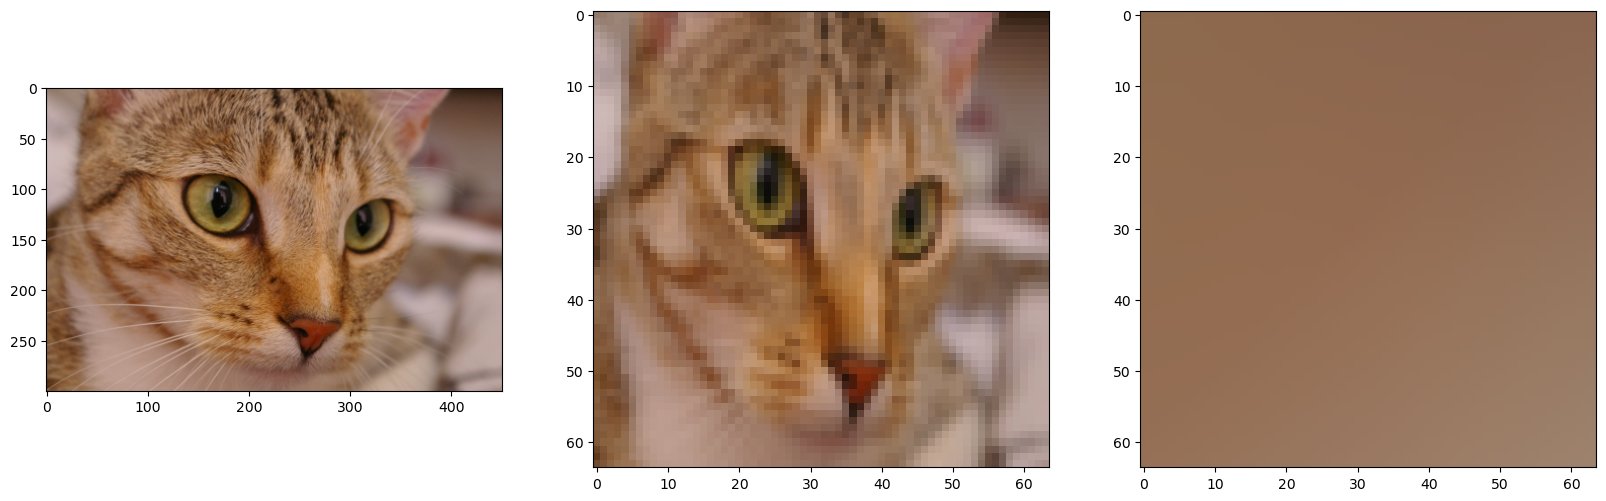

In [108]:
def view_output(prediction, image_shape=(64,64,3)):
    # Reshape it from 1D to 2D
    reconstructed_img = tf.reshape(prediction, image_shape)
    
    # Scale the values from [0,1] to [0, 255]
    reconstructed_img *= 255
    
    # Convert the tensor into a numpy array, and cast the type into a uint8.
    reconstructed_img = reconstructed_img.numpy().astype(np.uint8)
    
    # Look at our creation next to the original!
    fig, axes_array = plt.subplots(1,3, figsize=(20,10))
    axes_array[0].imshow(img)
    axes_array[1].imshow(smaller_img)
    axes_array[2].imshow(reconstructed_img)
    plt.show()
    
view_output(prediction)

# Improving Our Model
The first thing I'm going to change is the optimizer, and I'm going to use Adaptive Moment Estimation, or ADAM. The optimizer determines how and at what rate the weights of the network are updated. So having an efficient optimizer can greatly improve how a model learns.

Have a look at the loss compared to the training earlier with Stochastic Gradient Descent, you might notice that from as early as the first epoch we have significantly lower loss (low loss is good).

Lets also train for twice as long.

In [109]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=16, batch_size=1)

Epoch 1/16


2023-03-13 23:08:15.302796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4096/4096 [==============================] - 30s 7ms/step - loss: 0.0134
Epoch 2/16
4096/4096 [==============================] - 29s 7ms/step - loss: 0.0123
Epoch 3/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0119
Epoch 4/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0113
Epoch 5/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0109
Epoch 6/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0102
Epoch 7/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0095
Epoch 8/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0089
Epoch 9/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0085
Epoch 10/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0081
Epoch 11/16
4096/4096 [==============================] - 30s 7ms/step - loss: 0.0078
Epoch 12/16
4096/4096 [==============================] - 31s 7ms/step - loss: 0.0075


2023-03-13 23:16:19.102310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


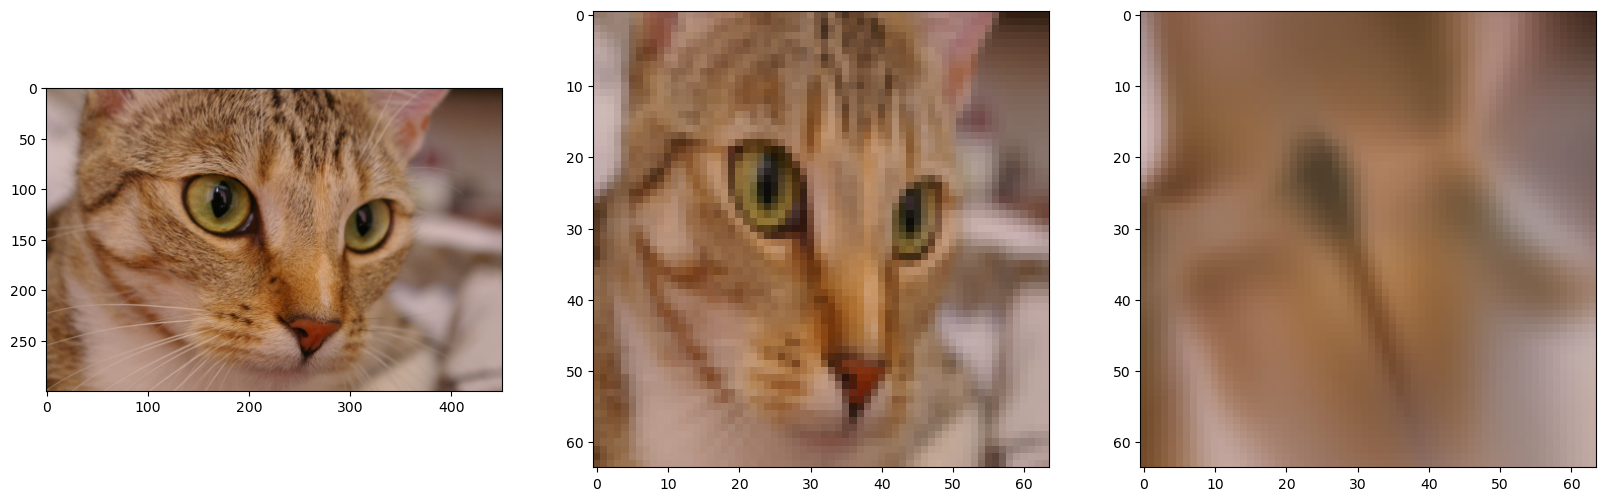

In [110]:
new_prediction = model.predict(X)
view_output(new_prediction)

# Doing more with our model
Our training coordinates use linspace to go from [-1, 1] in 64 steps in width and height. This is simply because we had 64 pixels in width and height. But we can interpolate [-1, 1] at any resolution we want. This extra easy because we can just reuse our get_mgrid() function.

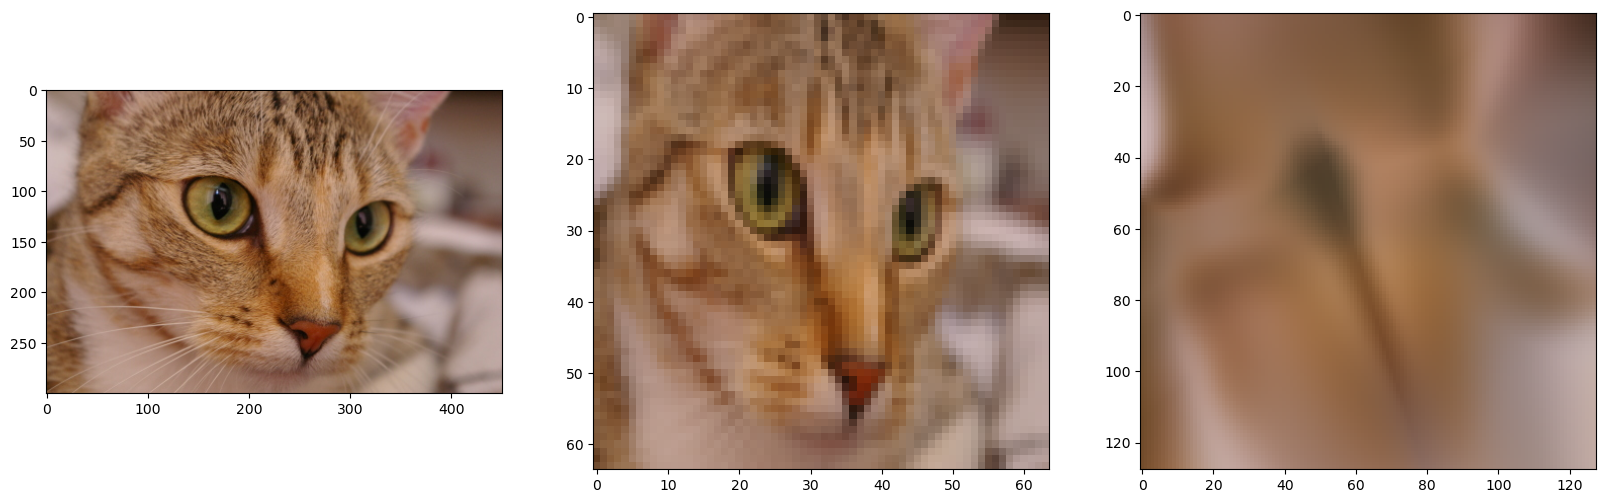

In [111]:
bigger_X = get_mgrid(128)
bigger_prediction = model.predict(bigger_X)
view_output(bigger_prediction, image_shape=(128, 128,3))

We have basically repurposed our humble model into something which can perform super-resolution!

We can also extend our input coordinates outside the bounds of [-1, 1]. This is getting into unknown territory now as this really is outside our original dataset (the image). At this point we're really asking the model to "imagine" what would be outside the boundaries of the original image (it's always nice to anthropomorphise these things).

Just to prove a point, we can give the model any two numbers and it will give us something

In [112]:
# Giving the model any old coordinates

a = model.predict([[0, 0]])
b = model.predict([[-2, 2]])
c = model.predict([[12, 99]])

print(a, b, c)

[[0.61142445 0.45185027 0.31753248]] [[0.0735113  0.04769038 0.0068383 ]] [[1.000000e+00 9.999765e-01 2.882682e-04]]


2023-03-13 23:16:29.305849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


To make new arbitrary input coordinates I'm going to re-write a version of get_mgrid. I could/should have just written the original function like this, but I wanted to keep it simple earlier.

NB. The asterix (*) in the function below spreads the array/tuple into its individual components. Much like '...' in JavaScript. So:

arr = [1,2,3]

func(*arr) === func(1, 2, 3)

In [113]:
def get_arbitrary_mgrid(sidelen, limits=(-1, 1)):
    '''Generates an arbitrary flattened grid of (x,y,...) coordinates of specified limits.'''
    width = np.linspace(*limits, sidelen)
    height = np.linspace(*limits, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

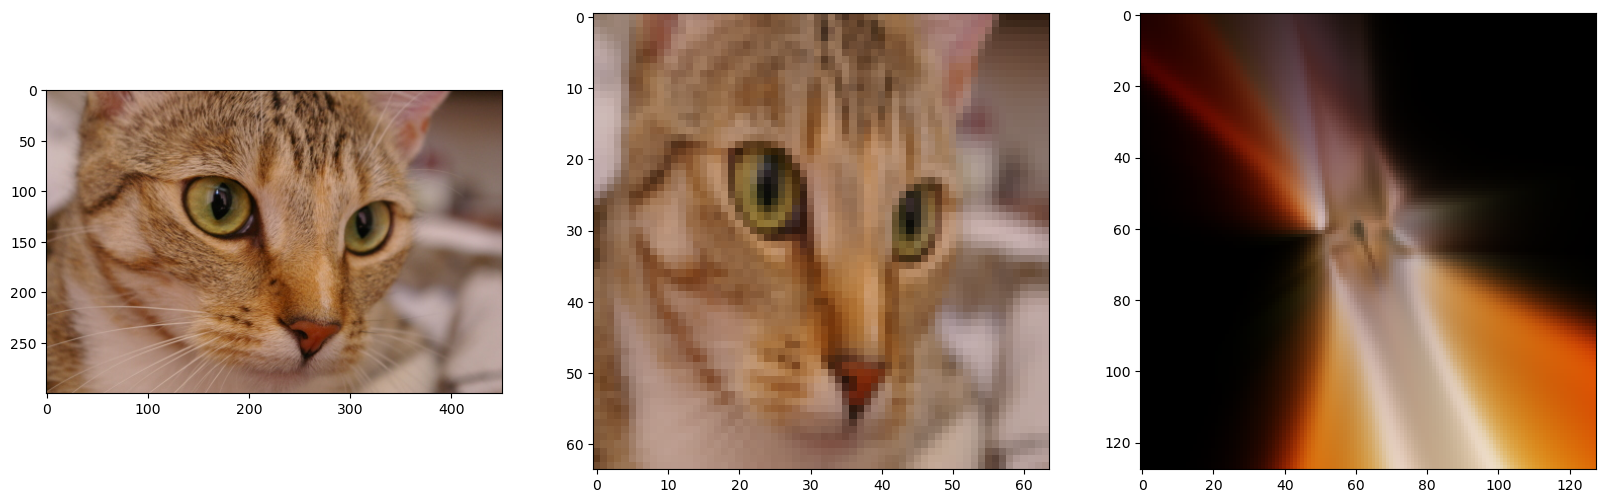

In [114]:
arbitrary_X = get_arbitrary_mgrid(128, limits=(-5, 5))
arbitrary_prediction = model.predict(arbitrary_X)
view_output(arbitrary_prediction, image_shape=(128, 128,3))

Or we could zoom in on a particular part of the image??

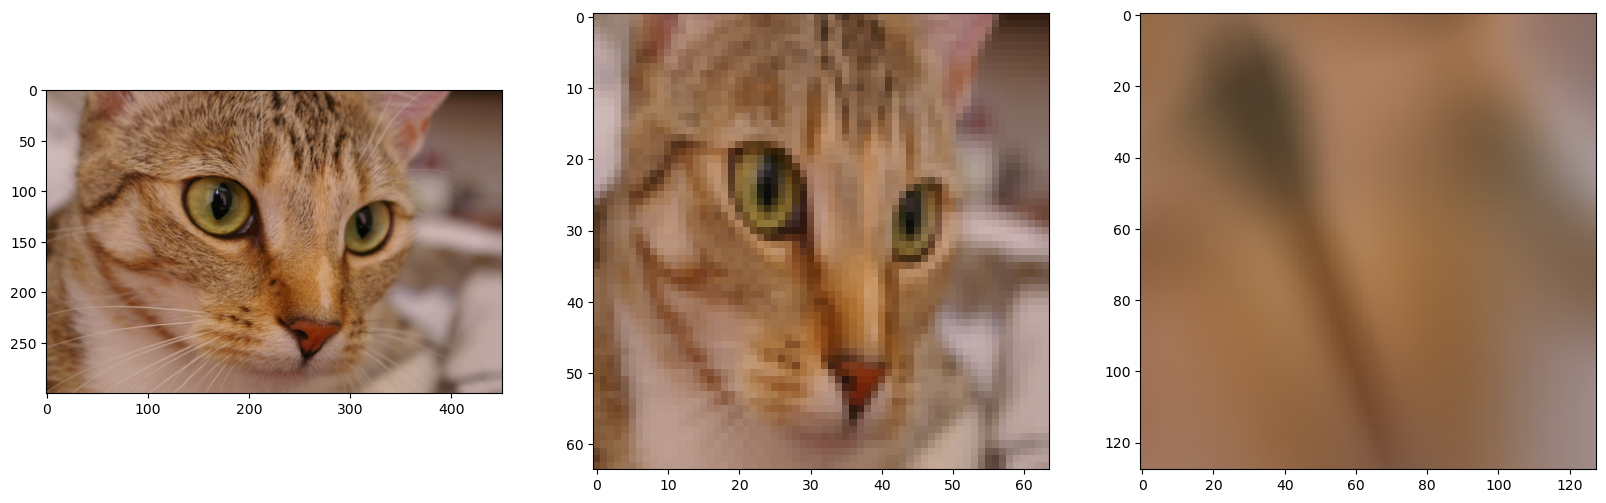

In [115]:
arbitrary_X = get_arbitrary_mgrid(128, limits=(-0.5, 0.7))
arbitrary_prediction = model.predict(arbitrary_X)
view_output(arbitrary_prediction, image_shape=(128, 128,3))

# How the image we have created differs from a normal image.

Firstly, CPPNs use algorithms to generate images, rather than using actual images or pixels. This means that the images created by CPPNs can be highly complex and may have patterns and shapes that are difficult to be created by using traditional image processing techniques.

Secondly, CPPN-generated images often have a more abstract and surreal meaning than ordinary images. This is because CPPN is not constrained by the rules and constraints of the physical world. This can result in images with a fantastic quality, with distorted or exaggerated shapes and colours. As in the example of the image generated above.

Finally, because CPPNs are capable of generating highly complex and detailed images, they can be used to create images that cannot be captured by traditional photographic or image processing techniques. This allows CPPNs to be a valuable tool for artists, designers and scientists who are interested in exploring new and innovative ways of creating and visualising data.